# Sentiment Analysis of Twitter Comments on US Airlines
Sentiment analysis is an important job for most US airlines. This notebook is written to build a natural language processing model to analyze sentiment based on twitter text comments on major US airlines. The data source can be found on Kaggle: https://www.kaggle.com/crowdflower/twitter-airline-sentiment. The csv file has been downloaded, which include the columns "text", "airline_sentiment". In the following cells, a model will be built to predict the sentiment (three categories: postive, neutral, negative) based on text comments. TensorFlow is used to build a model including layers of convolutional neural network, recurrent neural network and deep neural network. It has been found out that using dropout layers can significantly improve the overfitting issue. An accuracy of ~0.80 has been achived on the validation data set.

## 1. Import the libraries and data set

In [1]:
# import the libraries
import tensorflow as tf
import random
import csv
import numpy as np

In [2]:
# import the libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [3]:
# Define the key parameters
vocab_size = 10000
embedding_dim = 100
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [4]:
# Load the data
sentences = []
labels = []
csvfile = open('Tweets.csv', encoding='utf8')

csv_reader = csv.reader(csvfile, delimiter=',')
next(csv_reader)    

for row in csv_reader:
    sentences.append(row[10])
    if row[1] =='positive':
        labels.append(2)
    elif row[1] == 'neutral':
        labels.append(1)
    else:
        labels.append(0)

csvfile.close()

In [5]:
# Check the size of the data
print(len(sentences))
print(len(labels))

14640
14640


## 2. Split the data into training set and validation set, and preprocess the text to padded sequences
The test portion was defined as 0.1. Therefore, the data was split into training set and validation set based on the ratio of 0.9/0.1.

In [6]:
# Split the dataset to training set and test set, transfer the sentences to sequences and pad/truncate the sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size = len(word_index)


index_list = list(range(len(sentences)))
random.shuffle(index_list)

test_portion = 0.1
training_index = index_list[:int(len(sentences)*(1-test_portion))]
test_index = index_list[int(len(sentences)*(1-test_portion)):]

training_sentences = []
training_labels = []

test_sentences = []
test_labels = []

for n in training_index:
    training_sentences.append(sentences[n])
    training_labels.append(labels[n])
    
for n in test_index:
    test_sentences.append(sentences[n])
    test_labels.append(labels[n])

training_sequences = tokenizer.texts_to_sequences(training_sentences)
padded_training = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
training_labels = np.array(training_labels)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
padded_test = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_labels = np.array(test_labels)

print(np.shape(training_labels))
print(np.shape(padded_training))
print(np.shape(test_labels))
print(np.shape(padded_test))

(13176,)
(13176, 120)
(1464,)
(1464, 120)


## 3. Build and train the model 

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 30

history = model.fit(padded_training, training_labels, epochs=num_epochs, validation_data=(padded_test, test_labels))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 100)          1576900   
_________________________________________________________________
dropout (Dropout)            (None, 120, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1

## 4. Study the trend of loss and accuracy as number of epochs increases

Below loss and accuracy were plotted for both training data and validation data as function os number of epochs. It is clear that accuracy of validation set has not gone up significantly after ~5 epochs. 

<Figure size 432x288 with 0 Axes>

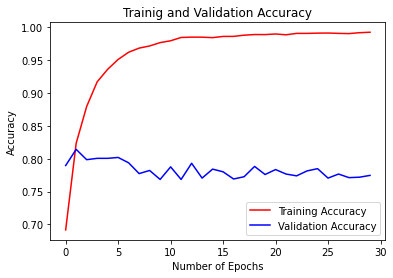

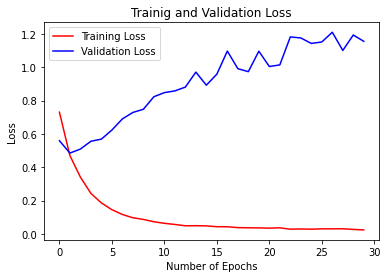

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt


acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

#plot accuracy for traiing set and validation set vs number of epochs
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Trainig and Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.figure()

# Plot loss for training set and validation set vs number of epochs
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Trainig and Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.figure()


## 5. References
Coursera Course by deeplearning.ai: Natural Language Processing in TensorFlow https://www.coursera.org/learn/natural-language-processing-tensorflow/home/welcome

Kaggle Data: Twitter US Airline Sentiment-Analyze how travelers in February 2015 expressed their feelings on Twitter: https://www.kaggle.com/crowdflower/twitter-airline-sentiment